# Short term trading strategies that work

In this notebook, strategies mentioned in the book 'Short term trading strategies that work' from Larry Connors are investigated. This book mainly focuses on short-term mean-reversion strategies in the US equity market.

In [1]:
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import pytz
import matplotlib.pyplot as plt
plt.style.use('bmh')

from vivace.backtest import (BacktestEngine, InstrumentDef,
                             Performance, signal, processing, rebase)
from vivace.backtest.engine import long_only_returns
from vivace.enums import Strategy, Weighting, PnLType

# Strategy 1
If the following conditions are met, go long the equity market for 5 days.
- It went down 3 days in a row
- Price is above 200 day MA. Rationale is to go long when long-term trend is up and capture temporal pullback.

In [2]:
instruments = ['SPY', 'QQQ', '^GDAXI', '^N225']

In [3]:
def run_strat_1(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.ConsecutiveSign(n_consecutive=3, lookback_direction=-1, position=1)
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine


def run_backtests(backtest_func, instruments):
    result = []

    for name in instruments:
        instrument = InstrumentDef(name, pnl_type=PnLType.ADJCLOSE_TO_ADJCLOSE.value)
        strat_engine = backtest_func(instrument)
        strat_equity_curve = strat_engine.calculate_equity_curve(calculate_net=False).rename(f'Strategy ({name})')
        long_only = long_only_returns(instrument, strat_equity_curve.index[0], strat_equity_curve.index[-1])
        long_only_equity_curve = long_only.add(1).cumprod().rename(f'Long-only ({name})')

        result.append(
            pd.concat((long_only_equity_curve, strat_equity_curve), axis=1).pipe(rebase)
        )
    return result

In [4]:
strategy_1_result = run_backtests(run_strat_1, instruments)

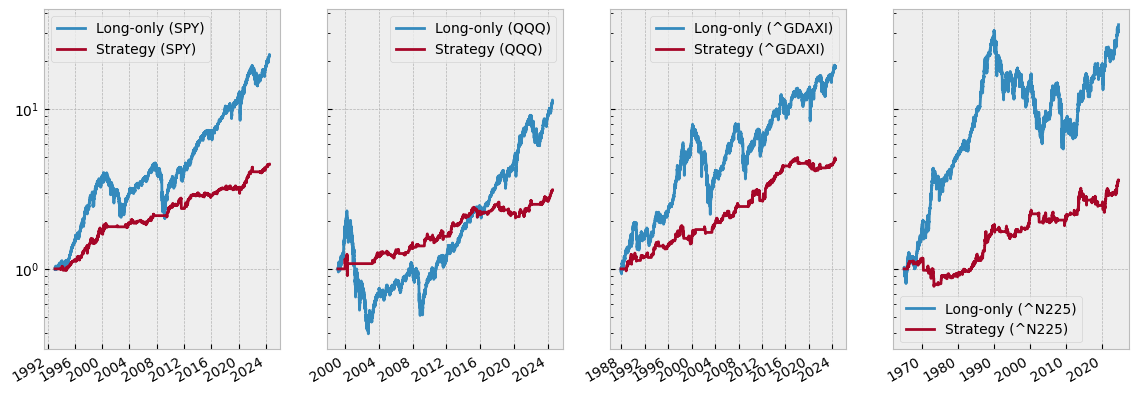

In [5]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_1_result):
    result.plot(ax=ax, logy=True)

In [6]:
pd.concat([i.pipe(Performance).summary() for i in strategy_1_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.097992,0.047955,0.095242,0.044891,0.079532,0.042878,0.060505,0.021960
Annualised vol,0.186621,0.071684,0.272762,0.098304,0.219008,0.080881,0.200603,0.075448
Sharpe ratio,0.525084,0.668981,0.349175,0.456661,0.363148,0.530143,0.301617,0.291066
Max drawdown,0.551894,0.140756,0.829639,0.265982,0.726848,0.233963,0.818712,0.335098
Calmar ratio,0.177555,0.340697,0.114799,0.168777,0.109421,0.183270,0.073903,0.065534
Skewness,-0.059613,-0.816570,0.209420,1.599175,-0.120632,-1.853228,-0.185682,-3.147221
Kurtosis,11.433479,40.788574,6.908068,72.758190,6.609482,69.888885,8.713641,115.321954
Worst return,-0.109424,-0.072473,-0.119788,-0.086648,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072473,-0.119788,-0.086648,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1w return,-0.197934,-0.081137,-0.246190,-0.246190,-0.216097,-0.128878,-0.243342,-0.127345


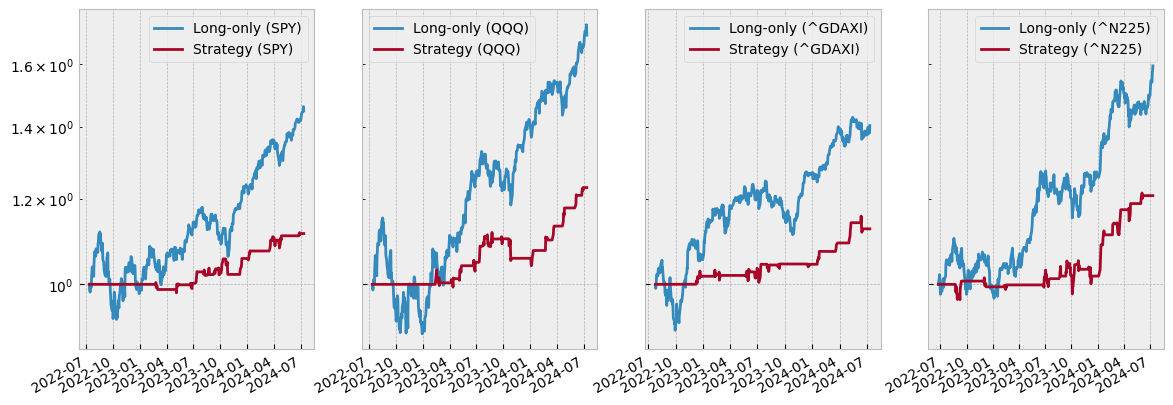

In [7]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_1_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 2

If the following conditions are met, go long the equity market for 5 days.
- It the market made new 10-day lows
- Price is above 200 day MA. Rationale is to go long when long-term trend is up and capture temporal pullback.

In [8]:
def run_strat_2(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.LocalMinimum(lookback=10, shift=1)
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [9]:
strategy_2_result = run_backtests(run_strat_2, instruments)

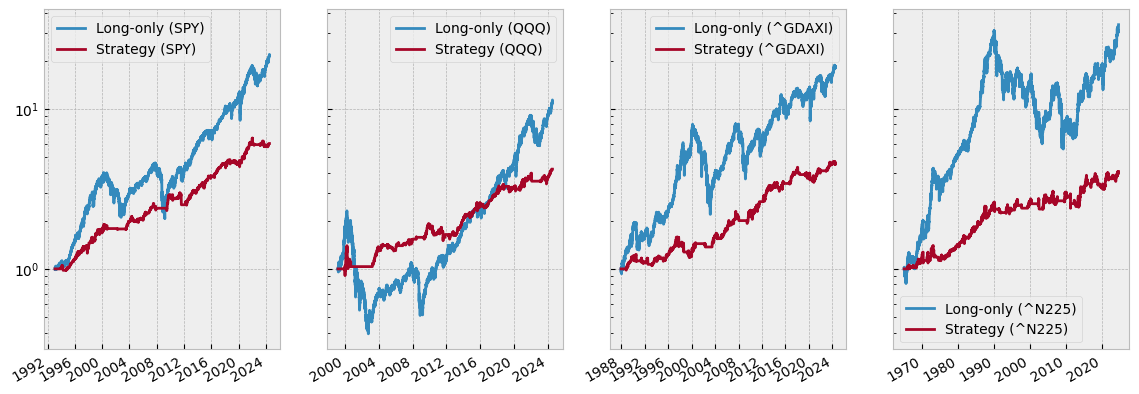

In [10]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_2_result):
    result.plot(ax=ax, logy=True)

In [11]:
pd.concat([i.pipe(Performance).summary() for i in strategy_2_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.097992,0.057447,0.095242,0.056722,0.079532,0.041240,0.060505,0.024115
Annualised vol,0.186621,0.081046,0.272762,0.112114,0.219008,0.087675,0.200603,0.086934
Sharpe ratio,0.525084,0.708817,0.349175,0.505934,0.363148,0.470381,0.301617,0.277393
Max drawdown,0.551894,0.163106,0.829639,0.282275,0.726848,0.256756,0.818712,0.219014
Calmar ratio,0.177555,0.352203,0.114799,0.200946,0.109421,0.160621,0.073903,0.110107
Skewness,-0.059613,-0.590512,0.209420,0.780177,-0.120632,-0.225141,-0.185682,-2.381379
Kurtosis,11.433479,28.577728,6.908068,48.260141,6.609482,16.444209,8.713641,80.405273
Worst return,-0.109424,-0.072473,-0.119788,-0.086648,-0.131434,-0.058299,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072473,-0.119788,-0.086648,-0.131434,-0.058299,-0.149009,-0.149009
Worst 1w return,-0.197934,-0.081137,-0.246190,-0.246190,-0.216097,-0.087830,-0.243342,-0.127345


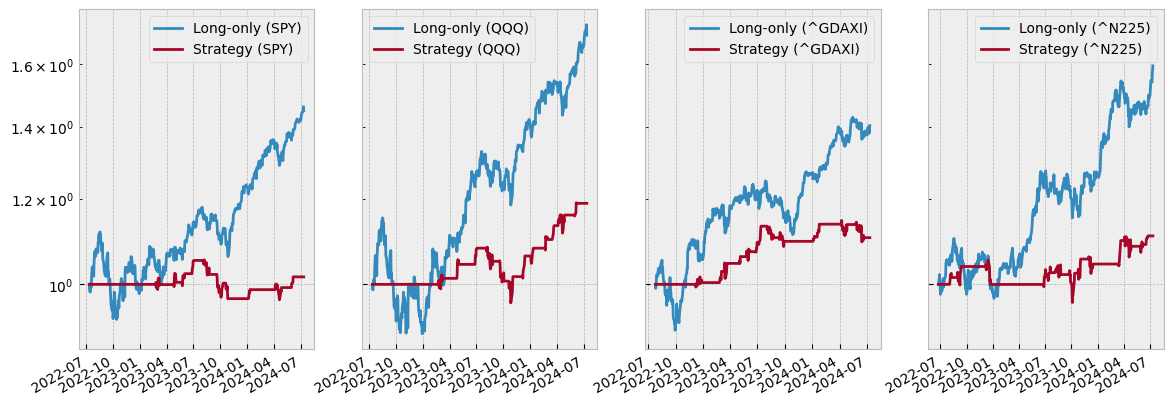

In [12]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_2_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 3

This strategy is the so-called "Double 7's strategy".

In [13]:
def run_strat_3(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Double7Connors(),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [14]:
strategy_3_result = run_backtests(run_strat_3, instruments)

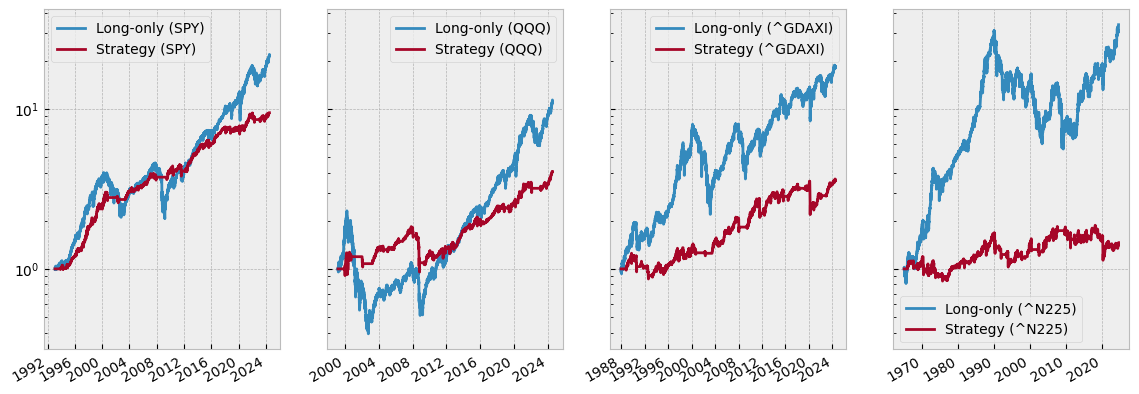

In [15]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_3_result):
    result.plot(ax=ax, logy=True)

In [16]:
pd.concat([i.pipe(Performance).summary() for i in strategy_3_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.097992,0.071533,0.095242,0.055320,0.079532,0.034859,0.060505,0.006506
Annualised vol,0.186621,0.097169,0.272762,0.141503,0.219008,0.116277,0.200603,0.105906
Sharpe ratio,0.525084,0.736167,0.349175,0.390947,0.363148,0.299795,0.301617,0.061429
Max drawdown,0.551894,0.153226,0.829639,0.480136,0.726848,0.382193,0.818712,0.395910
Calmar ratio,0.177555,0.466845,0.114799,0.115218,0.109421,0.091209,0.073903,0.016432
Skewness,-0.059613,-0.300307,0.209420,0.657920,-0.120632,-1.212365,-0.185682,-1.594377
Kurtosis,11.433479,18.109716,6.908068,33.282993,6.609482,37.653512,8.713641,44.969808
Worst return,-0.109424,-0.072473,-0.119788,-0.089557,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072473,-0.119788,-0.089557,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1w return,-0.197934,-0.111611,-0.246190,-0.246190,-0.216097,-0.200123,-0.243342,-0.159939


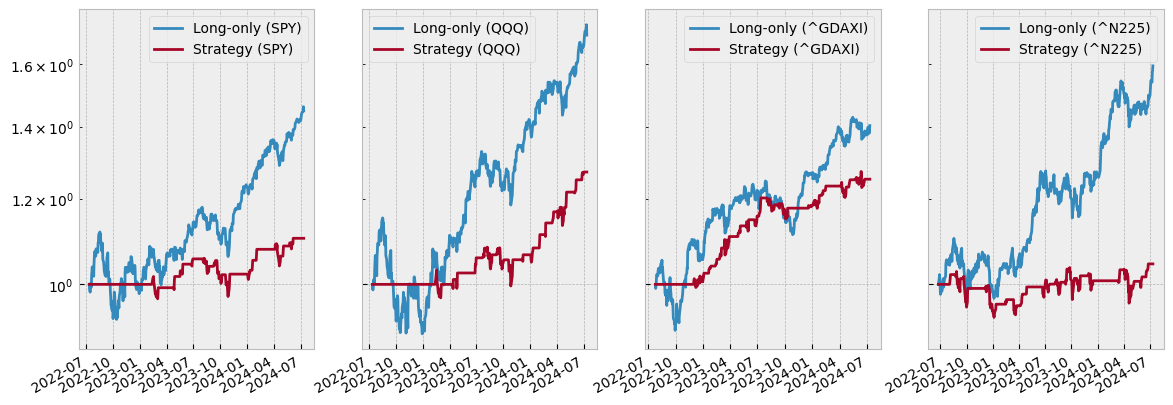

In [17]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_3_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 4
Month-end strategy which goes long when the following conditions are met:
- n days before month-end
    - (optional) only do so when the previous day is down
- The price is above 200 day MA

In [18]:
def run_strat_4(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.MonthEndLong(n_before=5, n_after=0, is_prev_neg=True),
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [19]:
strategy_4_result = run_backtests(run_strat_4, instruments)

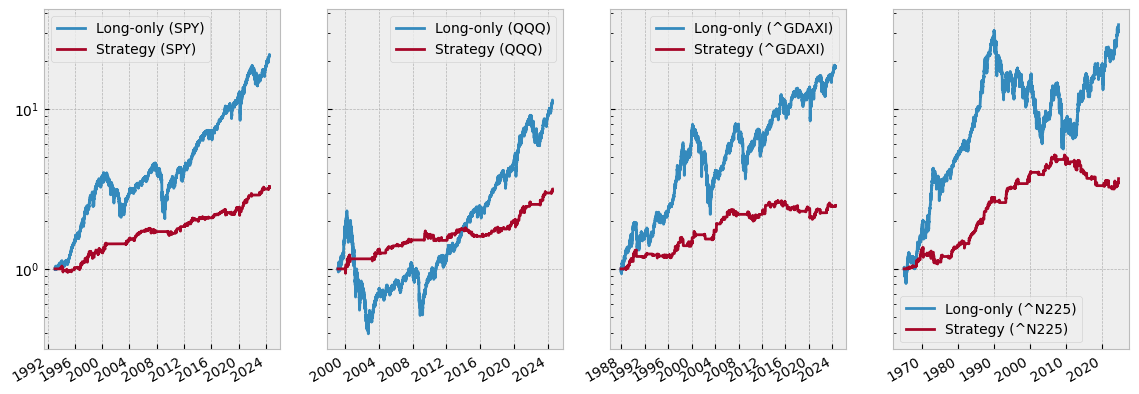

In [20]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_4_result):
    result.plot(ax=ax, logy=True)

In [21]:
pd.concat([i.pipe(Performance).summary() for i in strategy_4_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.097992,0.037696,0.095242,0.045413,0.079532,0.024941,0.060505,0.022361
Annualised vol,0.186621,0.061289,0.272762,0.080659,0.219008,0.065828,0.200603,0.058804
Sharpe ratio,0.525084,0.615055,0.349175,0.563020,0.363148,0.378878,0.301617,0.380259
Max drawdown,0.551894,0.111611,0.829639,0.131615,0.726848,0.238856,0.818712,0.387190
Calmar ratio,0.177555,0.337747,0.114799,0.345039,0.109421,0.104418,0.073903,0.057751
Skewness,-0.059613,-0.742310,0.209420,0.533483,-0.120632,-0.254655,-0.185682,-1.711012
Kurtosis,11.433479,47.209532,6.908068,40.483067,6.609482,27.668060,8.713641,74.520145
Worst return,-0.109424,-0.072473,-0.119788,-0.057516,-0.131434,-0.048098,-0.149009,-0.086856
Worst 1d return,-0.109424,-0.072473,-0.119788,-0.057516,-0.131434,-0.048098,-0.149009,-0.086856
Worst 1w return,-0.197934,-0.111611,-0.246190,-0.106267,-0.216097,-0.124379,-0.243342,-0.127345


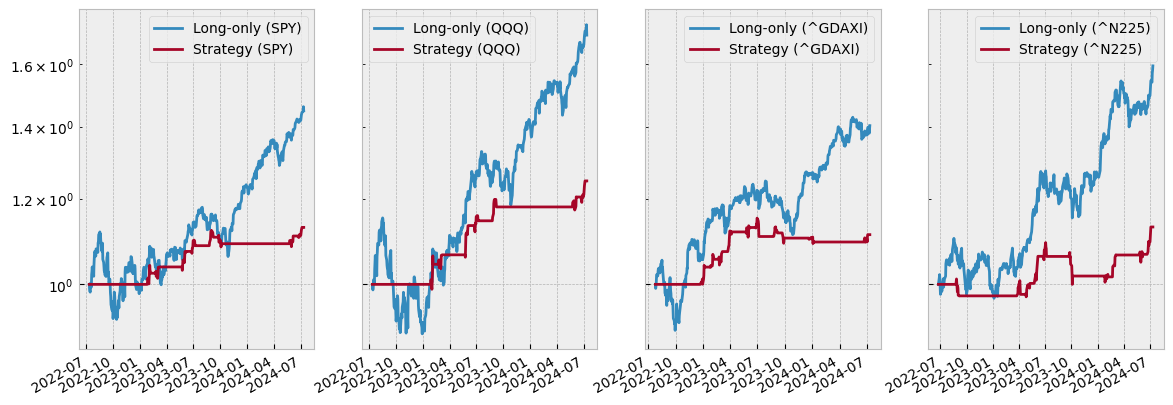

In [22]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_4_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Reference
- Connors, L.A. and Alvarez, C., 2009. Short Term Trading Strategies that Work: A Quantified Guide to Trading Stocks and ETFs. TradingMarkets Publishing Group.

In [23]:
print(f'Updated: {datetime.now(pytz.utc):%d-%b-%Y %H:%M}')

Updated: 12-Jul-2024 19:37
